In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import xlrd
import xlwt
import xlsxwriter
from pylab import rcParams


from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
utils = importr('utils')
'''utils.install_packages('vars')
utils.install_packages('dtwclust')
utils.install_packages('dtw')'''

"utils.install_packages('vars')\nutils.install_packages('dtwclust')\nutils.install_packages('dtw')"

Read countries from the excel sheet, remove the first column name because it is not a country

In [36]:
fiveYearCDS = pd.read_excel('EM_Risk_Monitor.xlsx', sheet_name='fiveYearCDS')
fiveYearCDS.fillna(fiveYearCDS.mean(), inplace=True)
countries =[]

for names in fiveYearCDS:
    countries.append(names)
del countries[0]

fiveYearCDS.to_csv('fiveYearCDS.csv', index_label=False)

In [37]:
timeline = fiveYearCDS['quarter']
time_df = pd.DataFrame({'quarter': timeline})

#for R.

In [38]:


fiveYearCDS.to_csv('fiveYearCDS.csv', index_label=False)

In [39]:
import rpy2
print(rpy2.__version__)

2.9.4


Read the excel for variables and for the data.

In [40]:
sheet_names = pd.read_excel('EM_Risk_Monitor.xlsx', sheet_name=None)
variables = [var for var in sheet_names]
emerging = {state: pd.DataFrame(columns=variables) for state in countries}

Map data by country, instead of by variable

In [41]:
emerging['Argentina']['fiveYearCDS'] = sheet_names['fiveYearCDS']['Argentina']

In [42]:
for i in variables:
    for j in countries:
        emerging[j][i] = sheet_names[i][j]

fill in non existant items, impute values

In [43]:
#Wrong way of filling in missing values - do it for completeness
for key in emerging:
    emerging[key].fillna(emerging[key].mean(), inplace=True)

add quarters and convert it to datetime

In [44]:
fiveYearCDS.quarter = pd.to_datetime(fiveYearCDS.quarter)
fiveYearCDS.set_index('quarter', inplace=True)



for i in countries:
    emerging[i]['quarter'] = timeline
    
for g in countries:
    emerging[g].quarter = pd.to_datetime(emerging[g].quarter)
    emerging[g].set_index('quarter', inplace=True)

In [45]:
#normalize and standardize
normalized ={count: pd.DataFrame(columns=variables) for count in countries}
standardized = {count: pd.DataFrame(columns=variables) for count in countries}

for state in countries:
    normalized[state] = (emerging[state] - emerging[state].mean())/(emerging[state].max() - emerging[state].min())
    standardized[state] = (emerging[state] - emerging[state].mean())/emerging[state].std()


In [46]:
from scipy.signal import detrend
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [47]:
for country in standardized:
    #print(copy_emerging[country].isnull().values.any())
    for var in variables:
        decomposition = sm.tsa.seasonal_decompose(standardized[country][var], model='additive')

Is the data stationary?????>????????

In [48]:
#difference data
randomized = {k: (standardized[k].diff().dropna()) for k in countries}

In [49]:
#testing for stationarity
#testing for stationary for all the countries
import statsmodels.tsa.stattools as ts

for i in countries:
    print(i)
    adResult = ts.adfuller(standardized[i]['fiveYearCDS'])
    print(adResult[1])

Argentina
0.1296067408622134
Brazil
0.030647739067125642
Chile
0.018785917554376325
Colombia
0.0002987118253897175
Hungary
0.170774109458891
Indonesia
0.005214061442678909
Malaysia
0.04732660001932463
Mexico
0.016172231458135705
Philippines
0.04985242808313357
Poland
0.13055975233456707
Romania
0.1576590798955212
Russia
0.022677726962634193
SouthAfrica
0.0756543307898478
Thailand
0.06179352758897618
Turkey
0.0027689727934344134
Ukraine
0.002643474214204346


Correlation relationship amongst variables per country

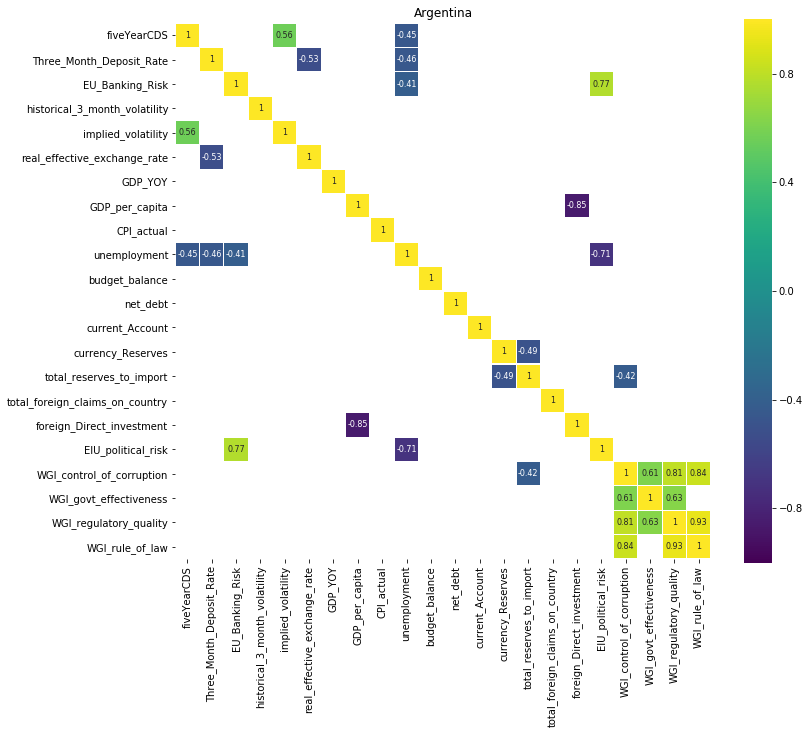

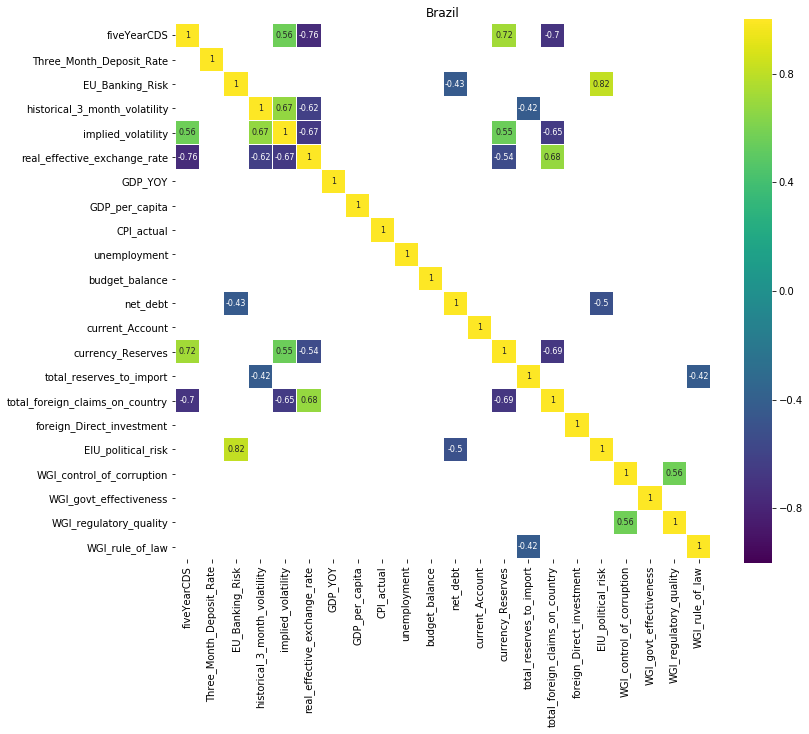

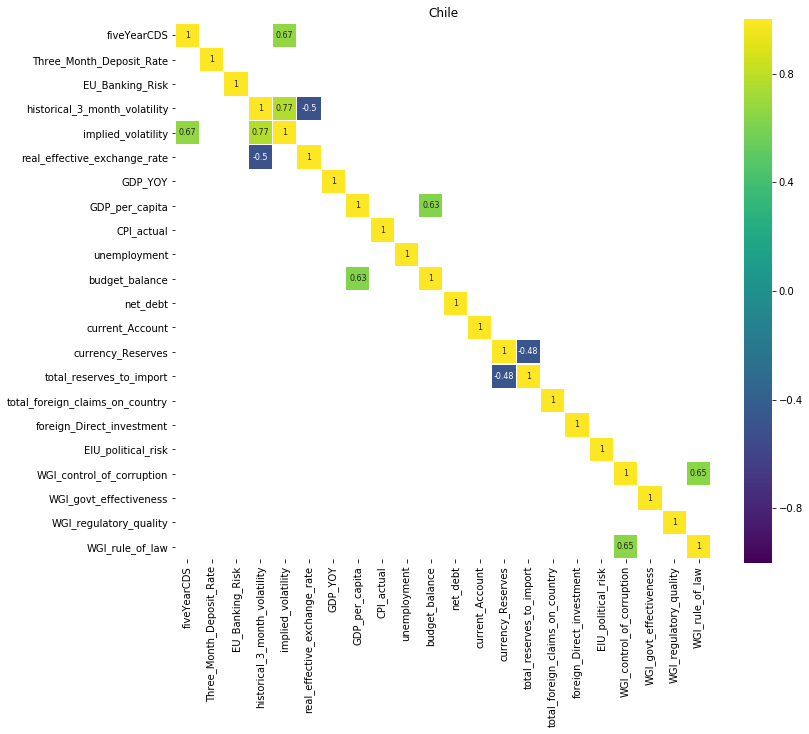

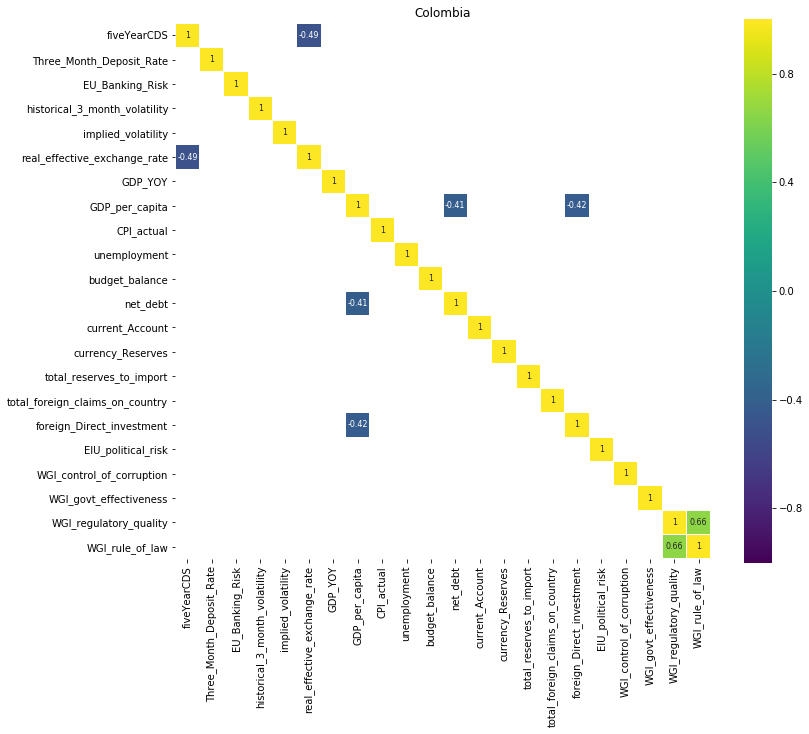

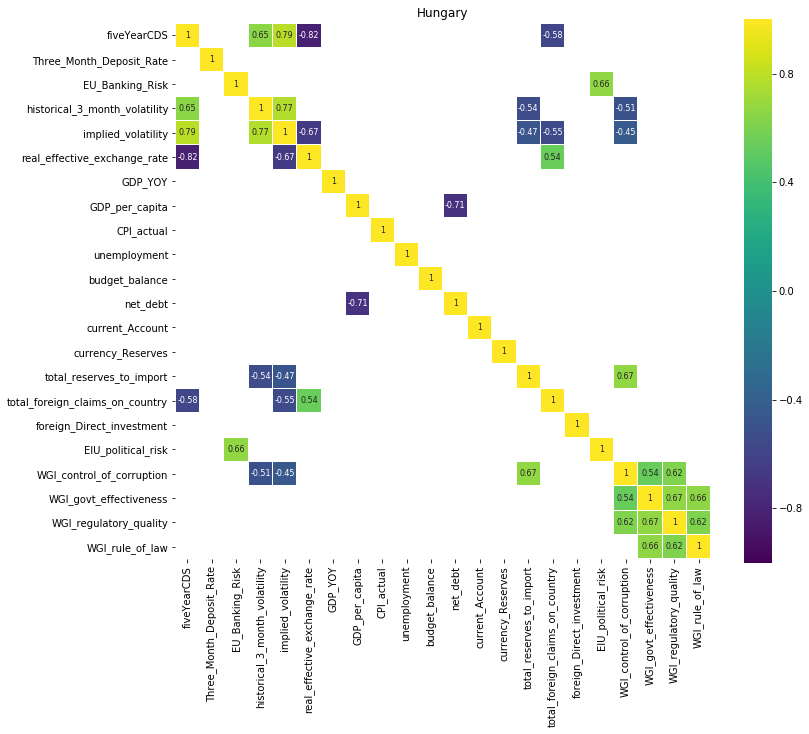

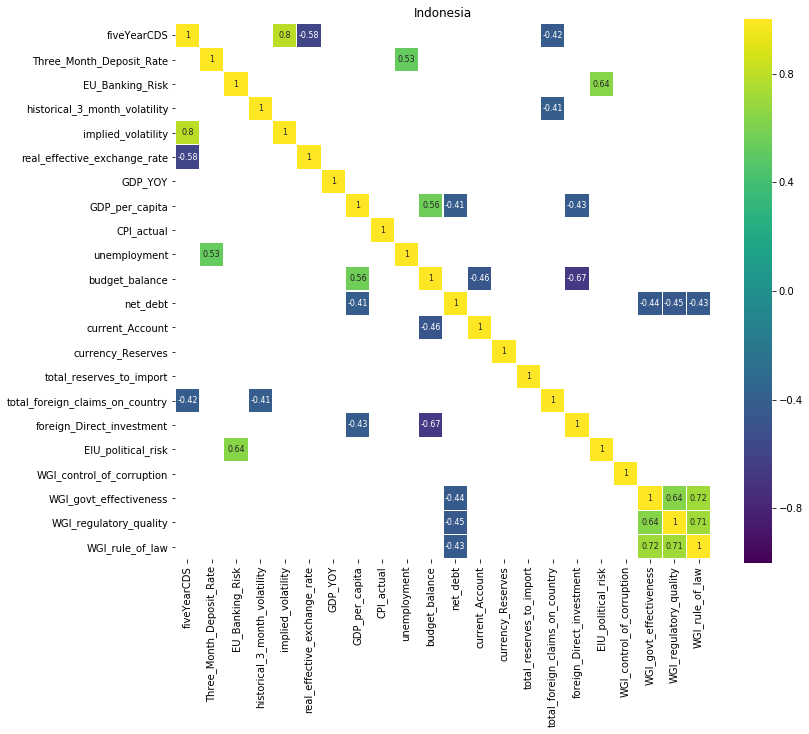

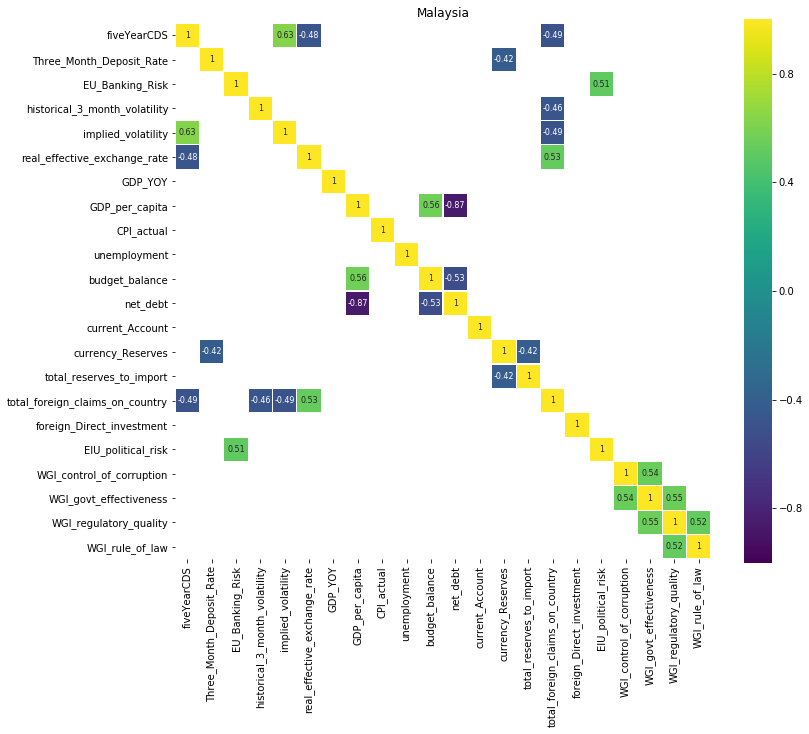

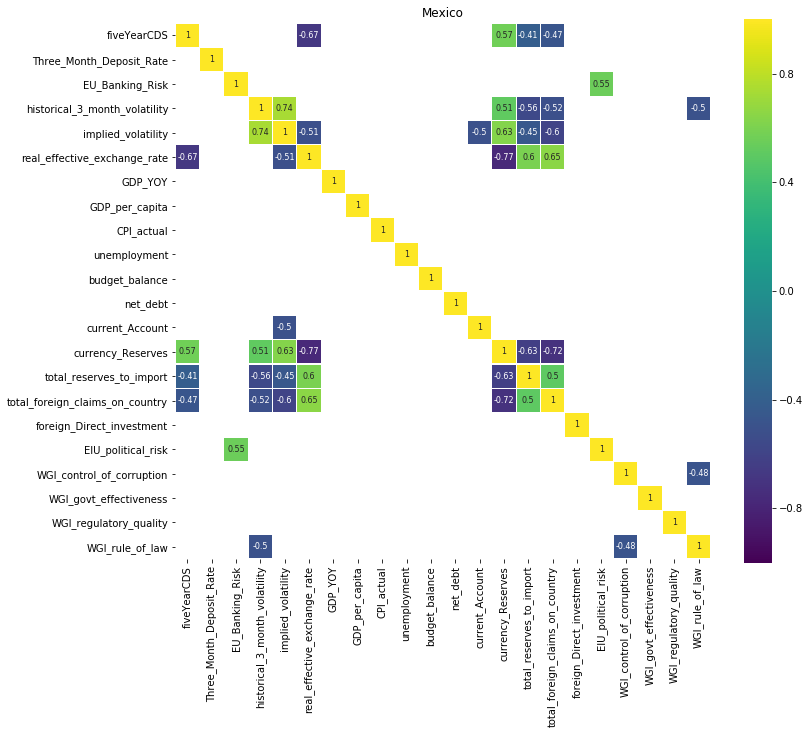

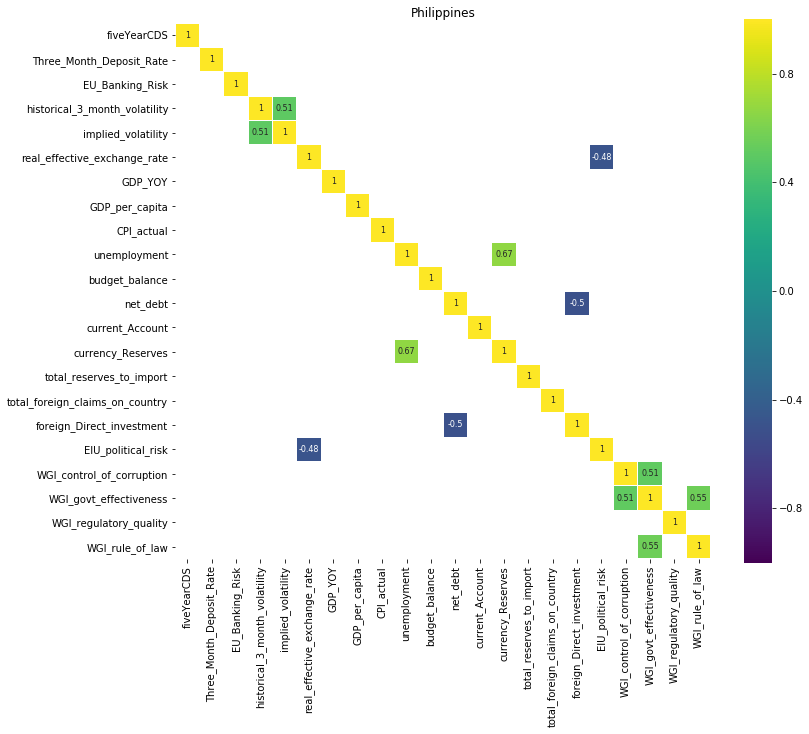

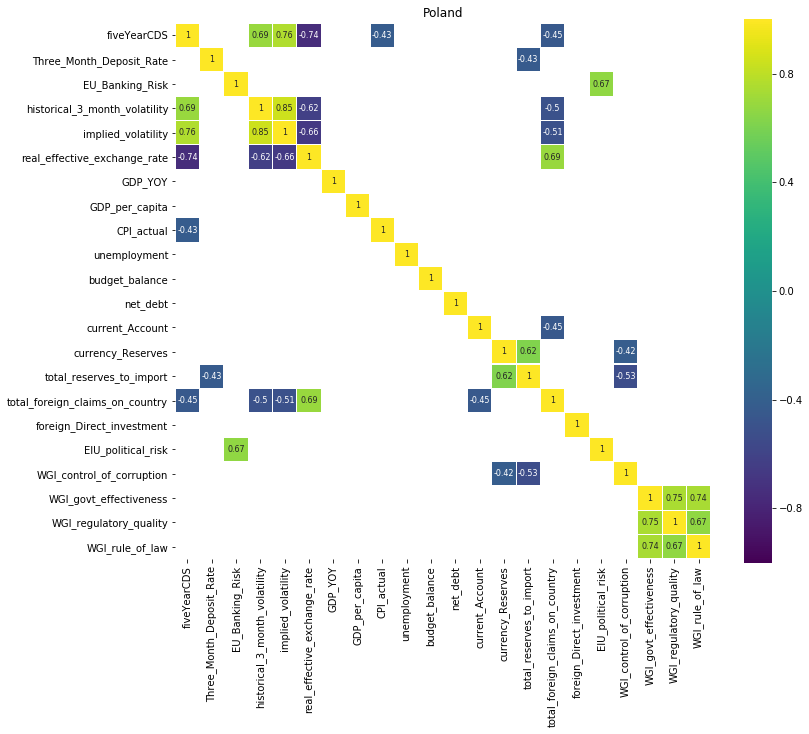

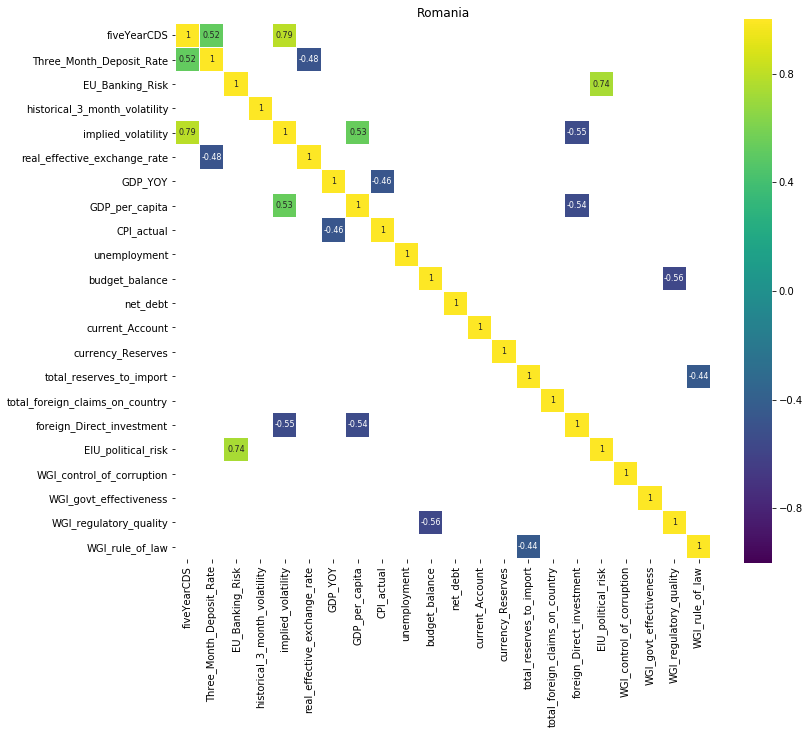

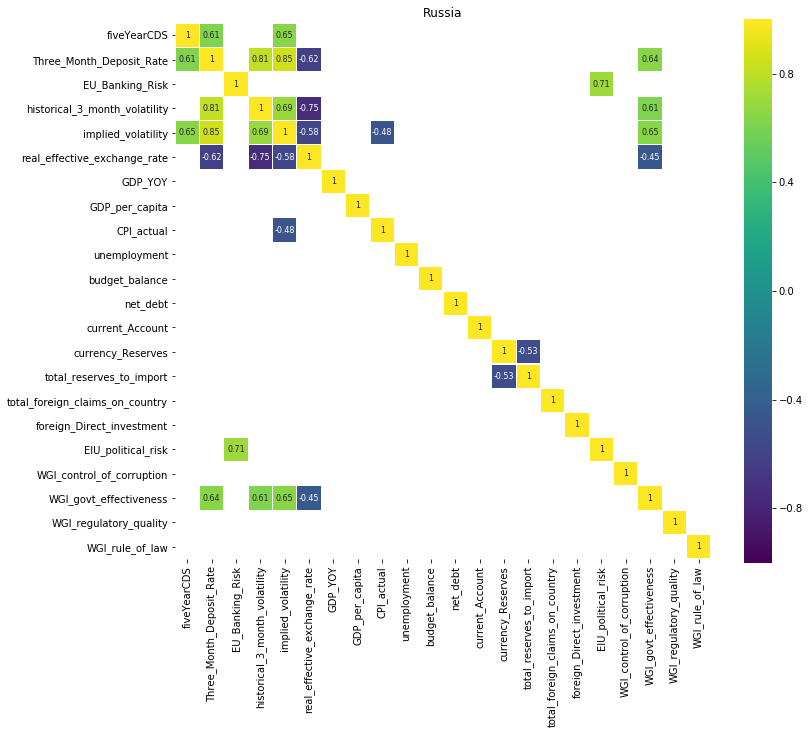

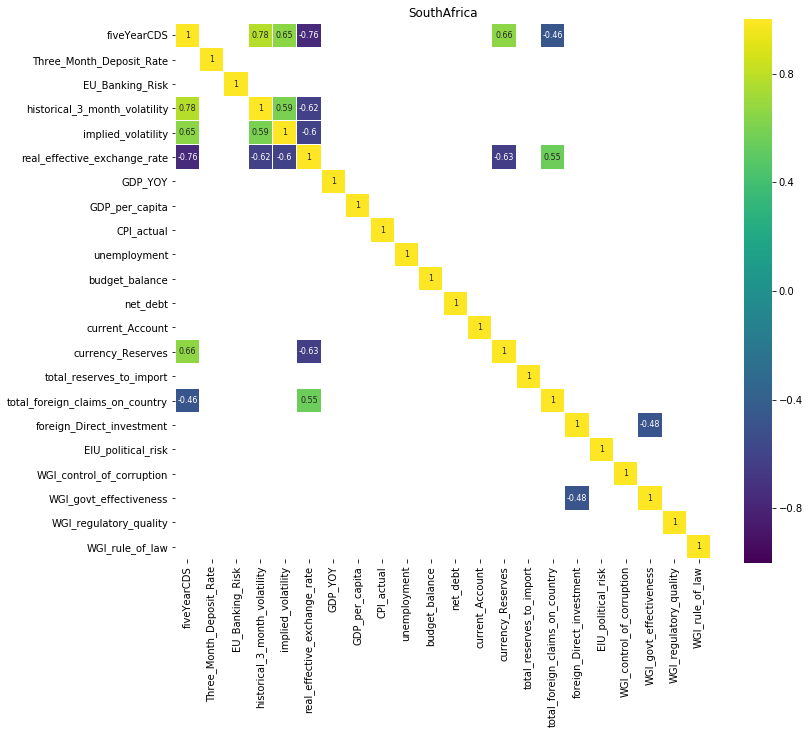

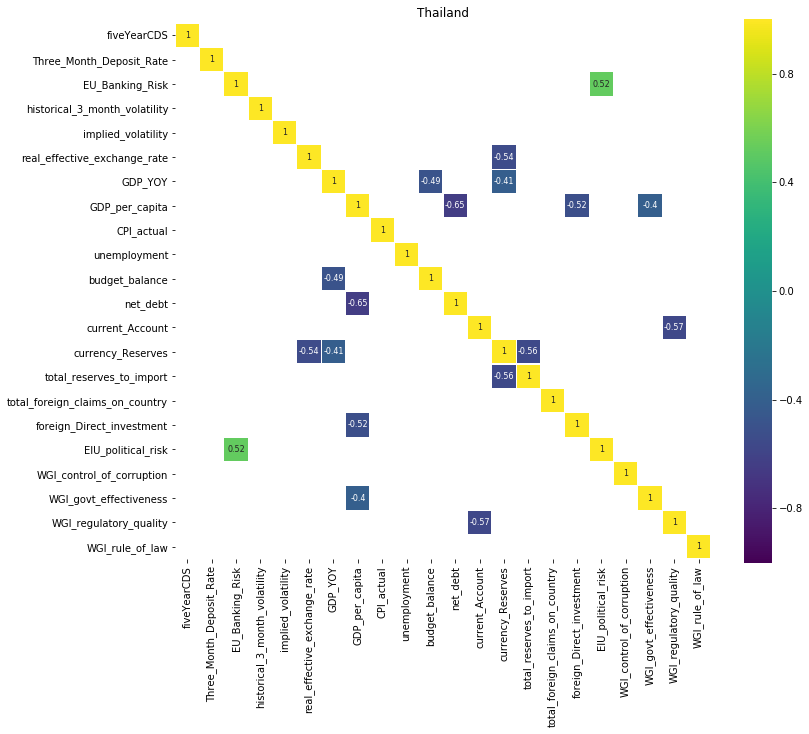

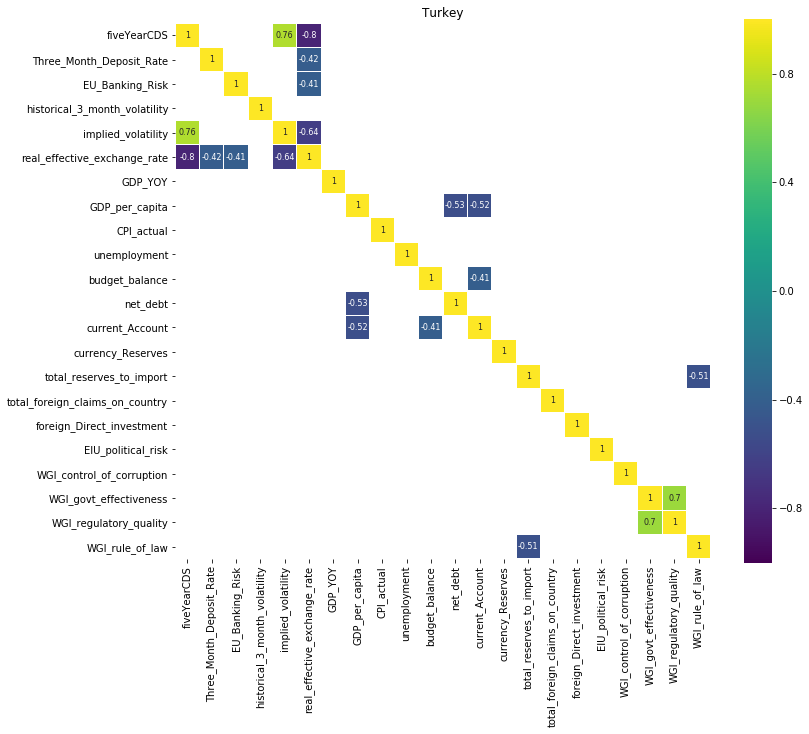

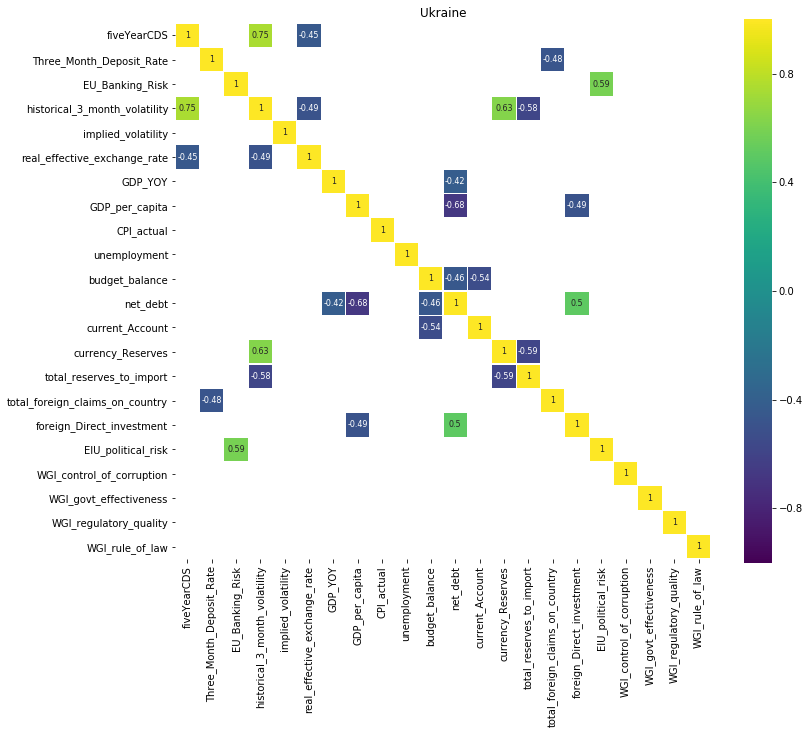

In [51]:
import seaborn as sns

for state in randomized:
    corre = randomized[state].diff().corr()
    plt.figure(figsize=(12,10))
    plt.title(state)
    plt.grid()
    sns.heatmap(corre[(corre >=0.5) | (corre <= -0.4)],
           cmap='viridis', vmax=1.0, vmin=-1.0, linewidth=0.1,
           annot=True, annot_kws={'size':8}, square=True);
    plt.show()


In [18]:
#remvoe the NaN values

IS there a corrrelation for some of the variables?
Are some of the variables strongly correlatted?
are there countries that Are affected more by certain variables

In [19]:

#g = sns.pairplot(random_2['Russia'][variables])

In [52]:
import warnings
warnings.filterwarnings('ignore')
import itertools

Model selection.
WHat kind of model to use for the estimation 

ARIMA is a model that is generally used initially because it works with most of time series data, and thus doesn't realy discriminate based on specific assumptions except for stationarity.

So the following is an arima model selection for CDS and time
run the model on all CDS data
choose the one with the smallest AIC - the smaller AIC generally tends to mean a better model.

so i made a loop to automatically choose the smallest aic and then fit that model.
Then I ran model diagnostics to test for normality, proof of stationarity and to see if I can trust potential predictions from this model.

In [53]:
#Which ARIMA, why ARIMA
#p,d,g account for seasonality, trend and noise
p = d = g = range(0,2)
pdg = list(itertools.product(p,d,g))
seasonal_pdg = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p,d,g))]

In [54]:
#find the best set of parameters that yield the best performance for a model.

CDS = {k: {} for k in countries}

for country in countries:
    param_AIC ={}
    AIC=[]
    for param in pdg:
        for param_seasonal in seasonal_pdg:
            #differenced = standardized[country].diff().dropna()
            mod = sm.tsa.statespace.SARIMAX(standardized[country]['fiveYearCDS'],order=param,
                                           seasonal_order=param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
            results = mod.fit()
            rounded=round(results.aic,2)
            AIC.append(rounded)
            param_AIC[rounded] = [param, param_seasonal]
        CDS[country] = param_AIC

In [55]:
#fitting the arima models
count_results = {}
for state in CDS:
    tiny = min(CDS[state])
    #differenced = standardized[state].diff().dropna()
    model = sm.tsa.statespace.SARIMAX(standardized[state]['fiveYearCDS'],
                                      order = (CDS[state][tiny][0][0], CDS[state][tiny][0][1], CDS[state][tiny][0][2]),
                                      seasonal_order = (CDS[state][tiny][1][0], CDS[state][tiny][1][1],
                                                       CDS[state][tiny][1][2], CDS[state][tiny][1][3]),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    results = model.fit()
    
    count_results[state] = results

In [56]:
#is it well fitted in the arima?
#This is diagnostic for the arima results

'''for state in count_results:
    print(state)
    #print(count_results[state].summary())
    #print(count_results[state].test_serial_correlation(None, None))
    count_results[state].plot_diagnostics(figsize=(16,8))
    plt.title(state)
    plt.show()'''

'for state in count_results:\n    print(state)\n    #print(count_results[state].summary())\n    #print(count_results[state].test_serial_correlation(None, None))\n    count_results[state].plot_diagnostics(figsize=(16,8))\n    plt.title(state)\n    plt.show()'

In [25]:
##Trying to predict the next 3 quarters
##prediction for the next 3 months

predicted ={}


for region in count_results:
    pred = count_results[region].predict(start=pd.to_datetime('2017-03-31'), end=pd.to_datetime('2018-12-31'), dynamic=False)

In [26]:
#standardized[state] = (emerging[state] - emerging[state].mean())/emerging[state].std()

In [27]:
#Continue with model selection
#but first let's do regression love

from sklearn import linear_model
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

for count in countries:
    print(count)
    #del emerging[count]['fiveYearCDS']
    lm = linear_model.LinearRegression()
    X = emerging[count]
    Y = fiveYearCDS[count]
    #model = sm.OLS(Y,X).fit()
    mod = lm.fit(X,Y)

Argentina
Brazil
Chile
Colombia
Hungary
India
Indonesia
Malaysia
Mexico
Peru
Philippines
Poland
Romania
Russia
South Africa
Thailand
Turkey
Ukraine


In [28]:
p_d = [(1,0), (0,1), (1,1)]

The following has a matrix problem, and I cannot download the package fromt the site because anaconda is blocked on our website.

so we going to try this again when anaconda.com issue has been fixed

In [29]:

'''Va_All = {k: {} for k in countries}
for state in countries:
    param_AIC={}
    AIC=[]
    for param in p_d:
        mode = sm.tsa.VARMAX(emerging[state][[variables[0], variables[1], variables[2], variables[3], variables[4], variables[5],
                                                   variables[6], variables[7], variables[8], variables[9], variables[10], variables[11],
                                               variables[12], variables[13], variables[14], variables[15], variables[16], variables[17],
                                               variables[18], variables[19], variables[20], variables[21], variables[22], variables[23]]],
                             order=param,
                             enforce_stationarity=False,
                            enforce_invertibility=False)
        outcome = mode.fit()
        rounded=round(outcome.aic,2)
        param_AIC[rounded] = param
    Va_All[state] = param_AIC'''

'Va_All = {k: {} for k in countries}\nfor state in countries:\n    param_AIC={}\n    AIC=[]\n    for param in p_d:\n        mode = sm.tsa.VARMAX(emerging[state][[variables[0], variables[1], variables[2], variables[3], variables[4], variables[5],\n                                                   variables[6], variables[7], variables[8], variables[9], variables[10], variables[11],\n                                               variables[12], variables[13], variables[14], variables[15], variables[16], variables[17],\n                                               variables[18], variables[19], variables[20], variables[21], variables[22], variables[23]]],\n                             order=param,\n                             enforce_stationarity=False,\n                            enforce_invertibility=False)\n        outcome = mode.fit()\n        rounded=round(outcome.aic,2)\n        param_AIC[rounded] = param\n    Va_All[state] = param_AIC'

In [30]:
'''model = sm.tsa.VARMAX(standardized['South Africa'][[variables[0], variables[1], variables[2], variables[3], variables[4], variables[5],
                                                   variables[6], variables[7], variables[8], variables[9], variables[10], variables[11]]], order=(1,0),
                     enforce_stationarity=False,
                     enforce_invertibility=False)

fitting = model.fit(maxiter=1000, disp=False)
#fitting = model.fit()
fitting.summary()'''

"model = sm.tsa.VARMAX(standardized['South Africa'][[variables[0], variables[1], variables[2], variables[3], variables[4], variables[5],\n                                                   variables[6], variables[7], variables[8], variables[9], variables[10], variables[11]]], order=(1,0),\n                     enforce_stationarity=False,\n                     enforce_invertibility=False)\n\nfitting = model.fit(maxiter=1000, disp=False)\n#fitting = model.fit()\nfitting.summary()"

In [31]:
##Time series classification.
#Dynamic TIme Warping
import math
def DTWDistance(s1, s2,w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return math.sqrt(DTW[len(s1)-1, len(s2)-1])

In [32]:
##split data into training and testing

from sklearn.model_selection import train_test_split

train, test = train_test_split(standardized['South Africa'], test_size=.2)

In [33]:
# apparently faster than dynamic time warping

def LB_keogh(colum1, colum2, r):
    LB_sum =0
    
    for ind, i in enumerate(colum1):
        lower_bound = min(colum2[(ind-r if ind-r >=0 else 0): (ind+r)])
        upper_bound = max(colum2[(ind-r if ind-r >=0 else 0): (ind+r)])
        
        if i>upper_bound:
            LB_sum = LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i+lower_bound)**2
            
    return math.sqrt(LB_sum)

In [34]:
from sklearn.metrics import classification_report

'''def knn(train, test, w):
    preds =[]
    
    for ind, i in enumerate(test):
        min_dist=float('inf')
        closest_seq=[]
        
        for j in train:
            if LB_keogh(i[:-1],j[:-1],5) <min_dist:
                dist=DTWdistance(i[:-1],j[:-1],w)
                if dist<min_dist:
                    min_dist = dist
                    closest_seq = j
        preds.append(closest_seq[-1])
    return classification_report[test[:,-1],preds]'''

"def knn(train, test, w):\n    preds =[]\n    \n    for ind, i in enumerate(test):\n        min_dist=float('inf')\n        closest_seq=[]\n        \n        for j in train:\n            if LB_keogh(i[:-1],j[:-1],5) <min_dist:\n                dist=DTWdistance(i[:-1],j[:-1],w)\n                if dist<min_dist:\n                    min_dist = dist\n                    closest_seq = j\n        preds.append(closest_seq[-1])\n    return classification_report[test[:,-1],preds]"

In [35]:
#k_means clustering


from sklearn.metrics import classification_report


def k_means_clust(data,num_clust,num_iter,w=5):
    #how does one solve this problem?
    centroids=random.sample(list(data),num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print(counter)
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]

        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]

    return centroids

In [36]:
judes =randomized['South Africa'].as_matrix()

In [37]:
'''centroids = k_means_clust(judes,4,10,5)

for i in centroids:
    plt.plot(i)
plt.show()'''

'centroids = k_means_clust(judes,4,10,5)\n\nfor i in centroids:\n    plt.plot(i)\nplt.show()'

In [38]:
##Find which countries ahve similiar cluster for CDS

In [39]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import k_means
import scipy.cluster.hierarchy as sch

In [40]:
clustering = AgglomerativeClustering(n_clusters=5, linkage='complete' )

In [41]:
x = np.array([[1,2],[1,4],[1,0],
             [4,2],[4,4],[4,0]])

In [42]:
africa = randomized['South Africa'].as_matrix()

In [43]:
clustering.fit(africa)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=5,
            pooling_func=<function mean at 0x0000003C9FB3C0D0>)

I have imported RPy2 for things I am unable to do in python that I can do in R.

This will simplify the framework because R will be called within Python

In [44]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
utils = importr('utils')
base = importr('base')

var = importr('vars')
dtwclust = importr('dtwclust')


In [45]:
#utils.install_packages('quantmod')
quantmod = importr('quantmod')

In [46]:

TSclust = importr('TSclust')
#pandas data frame to R datafram
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [49]:
for i in standardized:
    standardized[i].to_csv("Countries/"+i+".csv")